<br>
<img src="https://i.ibb.co/vj5ntsr/logo.png" width="120" height="40" align="left"><br>
<br>
<br>
<br>

# <font color=black><center>Take-home Assignment</center>
**Data Source:** Sent by email on 20 April 2021 from Kristóf Szabó - Gameloft Hungary - I started on 26th<br>
    
**Churn analysis:**<br>
1- Which missions are we losing most players at? [Jump to Answer](#Q1)<br>
2- Do we see different behavior depending on player level? (you can look at groupings of 5 or 10 levels) [Jump to Answer](#Q2)<br>
<br>
**Revenue analysis:**<br>
3- How much revenue did we generate with the event? [Jump to Answer](#Q3)<br>
4- Which levels generated more money [Jump to Answer](#Q4)<br>
<br>
**Recommendations:**<br>
5- We would like the candidate to propose some recommendations to improve future events in terms of participation and revenue, based on this data set. [Jump to Answer](#Q5)<br>


In [97]:
# Reading all libraries

import pandas as pd													# data manipulation
import matplotlib.pyplot as plt												# graphs
import seaborn as sns													# graphs
import numpy as np													# graphs
from scipy.stats import norm												# statistics
from sklearn.preprocessing import StandardScaler									# statistics
from scipy import stats													# statistics
from math import *													# advance calculation	
from matplotlib import cm												# graphs
from matplotlib.pyplot import figure											# graphs
import sys														# system functions
import warnings														# indicating warnings
warnings.filterwarnings('ignore')											# ignore by default
from matplotlib.ticker import LinearLocator										# graphs
pd.set_option('display.max_columns', None)										# show all columns
pd.set_option('display.max_rows', None)											# show all rows
np.set_printoptions(threshold=sys.maxsize)										# show arrays full
pd.set_option("display.max_colwidth", -1)										# show a complete text in a cell
pd.set_option('display.float_format', lambda x: '%.2f' % x)								# precision decimals pd
np.set_printoptions(precision=3)											# precision decimals np
from xlsxwriter.workbook import Workbook										# CSV writing
import csv														# CSV writing	
import xgboost as xgb													# prediction
import pickle														# prediction	
import sklearn														# mutual information
import statsmodels.api as sm												# coefficient
from sklearn.ensemble import RandomForestClassifier									# random forest
from sklearn import linear_model											# linear regression
import pymysql														# MySql connection
import psycopg2														# PostgreSQL database adapter
import datetime														# time conversions
import random														# randomchoice
import math as math													# maths
import statistics													# statistics
import glob														# paths and files management
import matplotlib.image as mpimg											# matplot image
from functools import reduce												# reduce
import folium														# interactive map
from folium.plugins import FastMarkerCluster										# interactive map
import cufflinks as cf													# Cufflink
import pandasql as ps													# connect to SQL
from google.cloud import bigquery											# upload to BigQuery
import google.datalab.bigquery as bq											# Pandas to BigQuery

In [186]:
# Reading the dataset
df = pd.read_csv('Game DA case study test dataset.csv')

In [94]:
# Show null values and duplicates in all columns. It uses isnull function for finding nulls and duplicated function for dups.
def nulldup(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = round((df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)*100, 3)
    missing_data = pd.concat([total, percent], axis=1, keys=['NullTotal', 'Null%'])
    for dup in missing_data.index:
        missing_data.at[dup,'DupTotal'] = df.duplicated(subset=[dup]).sum()
        missing_data.at[dup,'Dup%'] = round((df.duplicated(subset=[dup]).sum())/df.shape[0]*100,3)
    display(missing_data)
nulldup(df)

,NullTotal,Null%,DupTotal,Dup%
premium_currency_cost_of_skip,0,0.00,2032.00,99.61
users_skipped_mission,0,0.00,1974.00,96.77
users_starting_mission,0,0.00,1466.00,71.86
mission_chapter,0,0.00,1989.00,97.50
player_level,0,0.00,2000.00,98.04


In [95]:
# Count Values to see what we have in each column.It's a simple count_values along with a 'for' iteration.
def count(df):
    pd.set_option('display.max_rows', 6)
    for column in df.columns:
        print(column,':')
        display(df[column].value_counts(dropna=False))
        print('___________________________________','\n')
count(df)

player_level :


41    51
40    51
19    51
      ..
25    51
24    51
2     51
Name: player_level, Length: 40, dtype: int64

___________________________________ 

mission_chapter :


04_13    40
01_03    40
03_02    40
         ..
02_07    40
01_05    40
05_08    40
Name: mission_chapter, Length: 51, dtype: int64

___________________________________ 

users_starting_mission :


1472     28
1656     24
1840     22
         ..
5635     1 
19251    1 
3979     1 
Name: users_starting_mission, Length: 574, dtype: int64

___________________________________ 

users_skipped_mission :


0       1333
23      251 
46      107 
       ...  
644     1   
621     1   
2714    1   
Name: users_skipped_mission, Length: 66, dtype: int64

___________________________________ 

premium_currency_cost_of_skip :


135    640
90     560
15     400
      ... 
300    40 
150    40 
75     40 
Name: premium_currency_cost_of_skip, Length: 8, dtype: int64

___________________________________ 



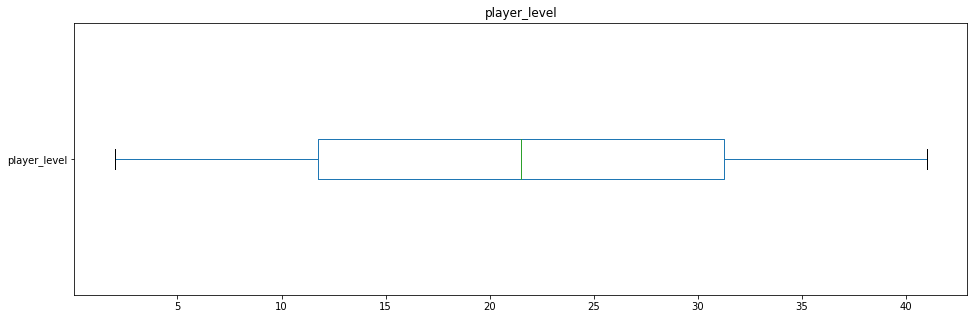

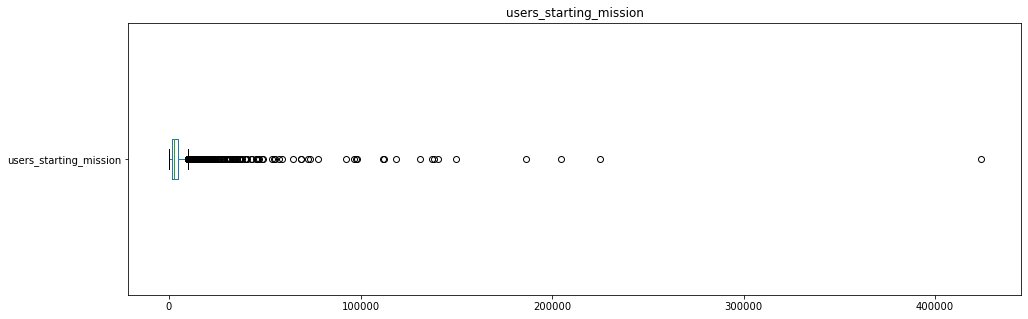

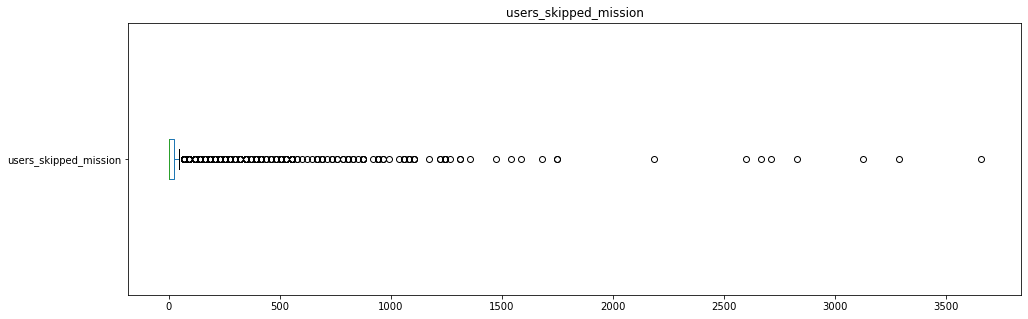

In [96]:
# Finding outliers using boxplot.
def my_boxplots(df):
    
    # We only care about continous features greater than 10 unique elements and not being a date.
    continuous_feature=[feature for feature in df.columns if (df[feature].dtypes != 'O') & (len(df[feature].unique())>10)\
                        & ('date' not in feature)]
    for feature in continuous_feature:
        df[feature].plot(kind='box', vert=False, figsize=(16,5));
        plt.title(feature)
        plt.show()

my_boxplots(df)

<a id='Q1'></a>
## <font color=blue><center>1- Which missions are we losing most players at?</center> ##


                        ***** players_lost by mission_name (top 10) ***** 


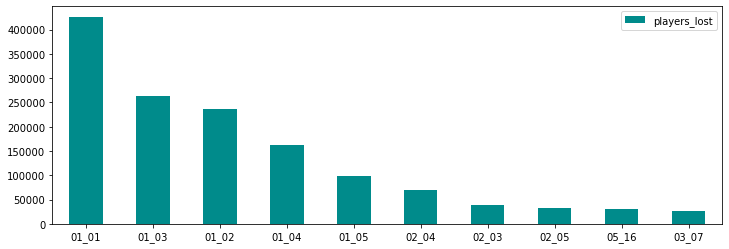


                        ***** percentage_lost by mission_name (top 10) ***** 


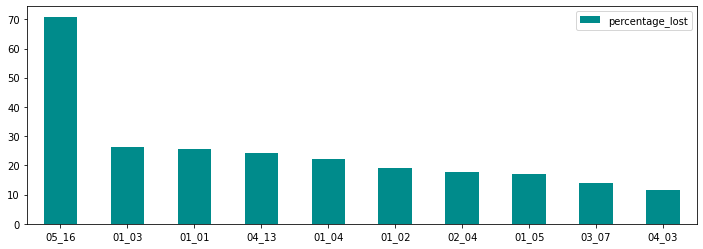

In [191]:
# Generate a table to calculate players_lost and the percentage of that 

dfresult1 = pd.DataFrame(data={'mission_name':[''],'players':['']}, columns=['mission_name','players'])

index = 0
for mission_name in df['mission_chapter'].unique():
    dftarget = df.loc[df['mission_chapter'] == mission_name]
    dfresult1.at[index,'mission_name'] = mission_name
    dfresult1.at[index,'players'] = dftarget['users_starting_mission'].sum()
    index = index + 1
    
dfresult1['players_lost'] = np.nan
dfresult1['percentage_lost'] = np.nan

for i in dfresult1.index:
    if i < 50:
        dfresult1.at[i,'players_lost'] = dfresult1['players'][i] - dfresult1['players'][i+1]
        dfresult1.at[i,'percentage_lost'] = round((dfresult1['players'][i] - dfresult1['players'][i+1])/\
                                             dfresult1['players'][i]*100,2)
    
# This code define 'color' locally for the sake of 'print' function
class color:
   GREEN = '\033[92m'
   BOLD = '\033[1m'
   END = '\033[0m'

# Generate some spaces for 'print' function
my_space = ' ' * 20

# Two for-loops. The first one for sum of NetProfit, the latter for Average
col = ['players_lost', 'percentage_lost']
for col in (col):
    dfresult1.sort_values(col, ascending = False)[:10].plot(kind='bar',x='mission_name',y=col, figsize=(12,4),color='darkcyan');
    plt.title(print('\n',color.BOLD,color.GREEN,my_space,'*****',col,"by mission_name (top 10)",'*****',color.END), fontsize=12)
    plt.xlabel('') 
    plt.xticks(rotation=0)
    plt.show();

<a id='Q2'></a>
## <font color=blue><center>2- Do we see different behavior depending on player level?</center> ##

,lvl_grouping,avg_percentage_lost,avg_players_lost
0,beginner,12.53,27762.84
1,intermediate,6.67,3804.20
2,advanced,4.23,1079.16
3,professional,2.44,391.00



              ***** players_lost by mission_name and lvl_grouping (top 10) ***** 


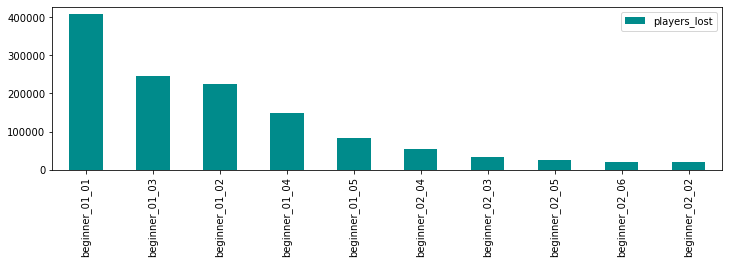


              ***** percentage_lost by mission_name and lvl_grouping (top 10) ***** 


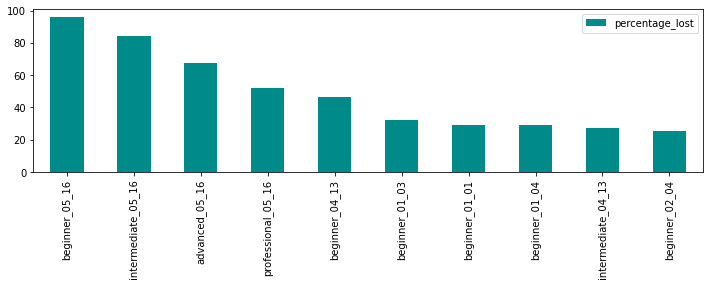

In [205]:
# The structure of this cell is the same as previous one but it generates data based on different levels
# This time, I will distinguish players_lost by 4 levels with each having bin size of 10 levels 
df2 = df.copy()
lvl2_11 = df2.loc[df2['player_level'].between(2,11)].index
lvl12_21 = df2.loc[df2['player_level'].between(12,21)].index
lvl22_31 = df2.loc[df2['player_level'].between(22,31)].index
lvl32_41 = df2.loc[df2['player_level'].between(32,41)].index
df2['lvl_grouping'] = np.nan
df2.at[lvl2_11,'lvl_grouping'] = 'beginner'
df2.at[lvl12_21,'lvl_grouping'] = 'intermediate'
df2.at[lvl22_31,'lvl_grouping'] = 'advanced'
df2.at[lvl32_41,'lvl_grouping'] = 'professional'


# Generate a table to calculate players_lost and the percentage of that 
dfresult2 = pd.DataFrame(data={'lvl_grouping':[''],'mission_name':[''],'players':['']},
                         columns=['lvl_grouping','mission_name','players'])

index = 0
for lvl_grouping in df2['lvl_grouping'].unique():
    dfinside = df2.loc[df2['lvl_grouping'] == lvl_grouping]
    for mission_name in dfinside['mission_chapter'].unique():
        dftarget = dfinside.loc[dfinside['mission_chapter'] == mission_name]
        dfresult2.at[index,'lvl_grouping'] = lvl_grouping
        dfresult2.at[index,'mission_name'] = mission_name
        dfresult2.at[index,'players'] = dftarget['users_starting_mission'].sum()
        index = index + 1
    
dfresult2['players_lost'] = np.nan
dfresult2['percentage_lost'] = np.nan

for i in dfresult2.index:
    if i < 203:
        dfresult2.at[i,'players_lost'] = dfresult2['players'][i] - dfresult2['players'][i+1]
        dfresult2.at[i,'percentage_lost'] = round((dfresult2['players'][i] - dfresult2['players'][i+1])/\
                                             dfresult2['players'][i]*100,2)
    
dfresult2.at[dfresult2.loc[dfresult2['mission_name'] == '05_17'].index,'percentage_lost'] = np.nan
dfresult2.at[dfresult2.loc[dfresult2['mission_name'] == '05_17'].index,'players_lost'] = np.nan
dfresult2

display(ps.sqldf("""

SELECT lvl_grouping, AVG(percentage_lost) avg_percentage_lost, AVG(players_lost) avg_players_lost
FROM dfresult2
GROUP BY 1
ORDER BY 2 DESC

"""))

# This code define 'color' locally for the sake of 'print' function
class color:
   GREEN = '\033[92m'
   BOLD = '\033[1m'
   END = '\033[0m'

# Generate some spaces for 'print' function
my_space = ' ' * 10
dfresult2['mission_name'] = dfresult2['lvl_grouping'] + '_' + dfresult2['mission_name']
# Two for-loops. The first one for sum of NetProfit, the latter for Average
col = ['players_lost', 'percentage_lost']
for col in (col):
    dfresult2.sort_values(col, ascending = False)[:10].plot(kind='bar', x='mission_name',y=col,figsize=(12,3),color='darkcyan');
    plt.title(print('\n',color.BOLD,color.GREEN,my_space,'*****',col,"by mission_name and lvl_grouping (top 10)"\
                    ,'*****',color.END), fontsize=12)
    plt.xlabel('') 
    plt.xticks(rotation=90)
    plt.show();
dfresult2.to_csv('dfresult2.csv', index=None)

<a id='Q3'></a>
## <font color=blue><center>3- How much revenue did we generate with the event?</center> ##

In [208]:
# First, calculating total_premium_collected by multiplying skipped_missions by currency
df['total_premium_collected'] = df['users_skipped_mission'] * df['premium_currency_cost_of_skip']

# Second, convert premium currency to dollars
round(df['total_premium_collected'].sum()*4.99/100,2)

224111.38

<a id='Q4'></a>
## <font color=blue><center>4- Which levels generated more money</center> ##

In [209]:
# revenue generation by player_level
question4 = ps.sqldf("""

SELECT player_level, CAST(ROUND(SUM(total_premium_collected)*4.99/100,0) AS INT) 'revenue_of_event ($)'
FROM df
GROUP BY 1
ORDER BY 2 DESC

""")

# saving data for PPT file
question4.to_csv('question4.csv', index=None)
question4

,player_level,revenue_of_event ($)
0,4,14099
1,3,13652
2,5,13503
3,6,12854
4,2,12355
5,7,9176
6,8,9164
7,11,8160
8,12,7695
9,10,7512


<a id='Q5'></a>
## <font color=blue><center>5- How to improve future events in terms of participation and revenue?</center> ##

**Improve product features to engage more users in Chapter 1, Mission 1 to 5 <br>
<br>
Fix product issues with mission 5 Chapter 16<br>
<br>
Focus on improving the design for lvl_grouping of beginner<br>
<br>
Focus on the users with the early level to increase revenue**<br>
